# 1D Plasticity Theory

In [21]:
from matplotlib import pyplot as plt
import numpy as np

## Loading only (NO History)

In [22]:
E_E = pow(10,7)
E_P = pow(10,6)

def kin_hard(): 
    return 1e6

def E_EP(E_E,E_P,H):
    return E_E/(E_E+kin_hard()+E_P)*( kin_hard() + E_P)

eng_strain = np.linspace(0,4.0,num=400)

k_init = pow(10,7)
eng_strain_init = k_init/E_E

In [23]:
eng_stress = np.empty(eng_strain.size);
for (i,element) in enumerate(eng_strain):
    if eng_strain_init > element:
        eng_stress[i] = E_E * element
    else:
        eng_stress[i]= k_init + E_EP(E_E,E_P,kin_hard) *(element-eng_strain_init)

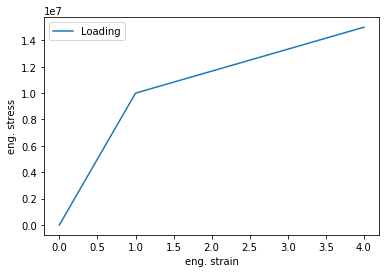

In [24]:
plt.xlabel('eng. strain')
plt.ylabel('eng. stress')
plt.plot(eng_strain,eng_stress,label="Loading")
plt.legend()
plt.show()

## Elasto-Plastic Increments

In [25]:
# SUBSEQUENT LOADING, First:+, Second:-
eng_strain = np.append(eng_strain,eng_strain[::-1])

eng_stress = np.empty(eng_strain.size);


In [26]:
# yield condition: isotropic linear hardening
def F(stress,strain_p,strain_p_eff,H):
    return abs(stress - H()*strain_p) - (k_init + E_P*strain_p_eff)

In [27]:
# consistency parameter
def lam(E_E,E_P,H,flow):
    return flow * E_E/(E_E+H()+E_P)

# flow rule
def flow(stress,p_strain,H):
    return np.sign(stress-H()*p_strain)


# SETUP
strain_increments = np.empty((eng_strain.size -1))

for i in range(eng_strain.size -1):
    strain_increments[i]=eng_strain[i+1]-eng_strain[i]
    
class State:
    ELASTIC, PLASTIC = range(2)
    
p_strain = p_strain_eff = stress = 0;
state = State.ELASTIC

# ALGORITHM
for (i,strain_inc) in enumerate(strain_increments):  
    # Attribute all strain to stress dsigma = E^e * depsilon
    stress_inc = E_E*(strain_inc)
    # Compute F(sigma,q,alpha)
    rest = F(stress+stress_inc,p_strain,p_strain_eff,kin_hard)
    if(rest<=0):
        # Elastic straining only(F<0): Hooke's Law applies (or just put everything into stress)
        stress += stress_inc
        state = State.ELASTIC
        assert F(stress,p_strain,p_strain_eff,kin_hard) <= 0
    else:
        if(state == State.ELASTIC):
            # In a state change we need to close the stress gap between elastic stress (with Hooke's Law)
            # and elastoplastic stress, s.t. F=0. | -> E -> | -> EP -> |
            
            # Subtract from stress_inc the plastic 
            e_stress_inc = (stress_inc-flow(stress,p_strain,kin_hard)*rest)
            stress += e_stress_inc
            e_strain_inc=e_stress_inc/E_E
            # The strain not needed to close the gap already contributes to the elastoplastic straining
            strain_inc = strain_inc - e_strain_inc
            state = State.PLASTIC  
            assert abs(F(stress,p_strain,p_strain_eff,kin_hard)) < 1e-7
            
        # Elastoplastic straining (F=0) | -> EP -> |
        stress += E_EP(E_E,E_P,kin_hard)*(strain_inc)
        p_strain += flow(stress,p_strain,kin_hard)*strain_inc *lam(E_E,E_P,kin_hard,flow(stress,p_strain,kin_hard))
        p_strain_eff += abs(strain_inc *lam(E_E,E_P,kin_hard,flow(stress,p_strain,kin_hard)))
        assert abs(F(stress,p_strain,p_strain_eff,kin_hard)) < 1e-7
    eng_stress[i+1] =stress;

## Bauschinger effect:
more stress needed in reversed direction to get back to 0 strain

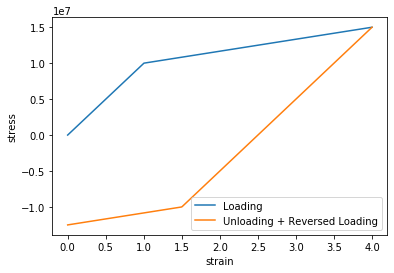

In [28]:
plt.xlabel('strain')
plt.ylabel('stress')
strain = np.split(eng_strain,2)
stress = np.split(eng_stress,2)
plt.plot(strain[0],stress[0],label="Loading")
plt.plot(strain[1],stress[1],label="Unloading + Reversed Loading")
plt.legend()
plt.show()